In [1]:
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_tuner as kt
#import tensorflowjs as tfjs
from tensorflow import keras
from keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import time

### Carga de datos, protocolo de separación

In [2]:
data_train = dict(X=[],Y=[])
data_test  = dict(X=[],Y=[])
        
for i in range(1,4):
    train = pd.read_pickle('train_clselfie_v4_{}.pickle'.format(i))
    data_train['X'].extend(train['X'])
    data_train['Y'].extend(train['Y'])
        
test = pd.read_pickle('test_clselfie_v4.pickle')
data_test['X'].extend(test['X'])
data_test['Y'].extend(test['Y'])

data_train['X'] = np.array(data_train['X'])        
data_train['Y'] = np.array(data_train['Y'])
                
data_test['X'] = np.array(data_test['X'])
data_test['Y'] = np.array(data_test['Y'])  

print('Total Train Data X:',data_train['X'].shape,'Y:',data_train['Y'].shape)
print('Total Test  Data X:',data_test['X'].shape,'Y:',data_test['Y'].shape)

Total Train Data X: (28152, 208, 208, 1) Y: (28152, 5)
Total Test  Data X: (2783, 208, 208, 1) Y: (2783, 5)


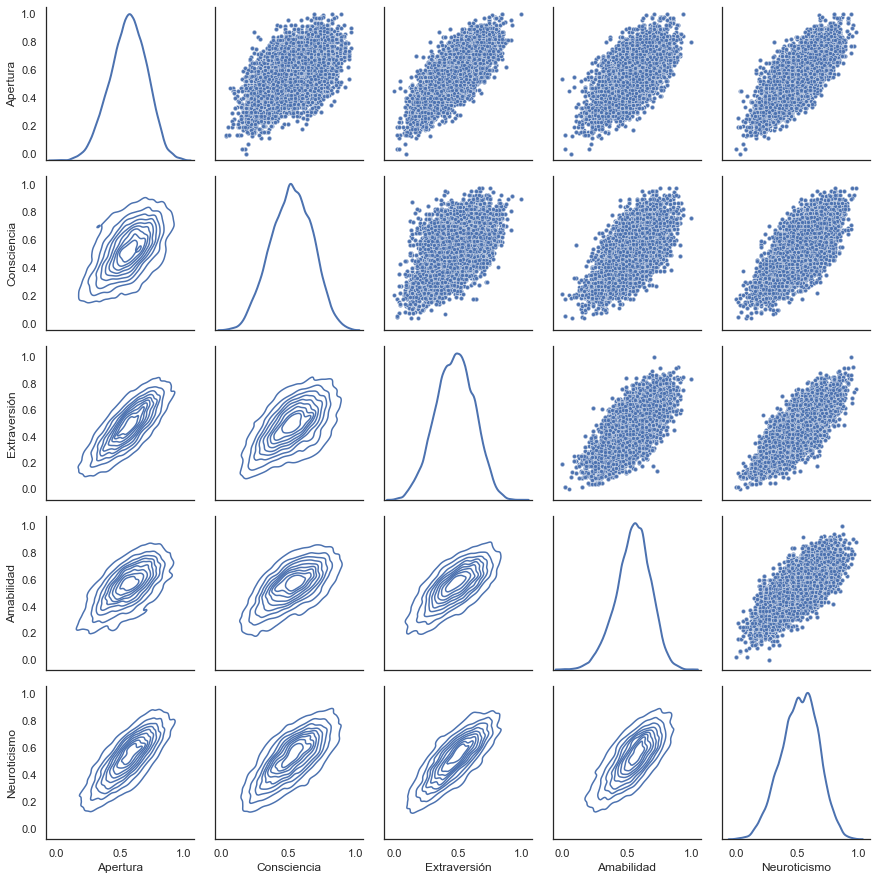

In [18]:
import seaborn as sns
sns.set_theme(style="white")

df=pd.DataFrame(data_train['Y'], columns=['Apertura','Consciencia','Extraversión','Amabilidad','Neuroticismo'])

g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)
#g.savefig('pairplot')

### Normalización, transformación, aumento de datos

In [3]:
train_x = []; test_x = [];

for i in range(len(data_train['X'])):
    train_x.append(data_train['X'][i] / 255)

for i in range(len(data_test['X'])):
    test_x.append(data_test['X'][i] / 255)
        
data_train['X'] = np.array(train_x)
data_test['X'] = np.array(test_x)

print('Total Train Data X:',data_train['X'].shape,'Y:',data_train['Y'].shape)
print('Total Test  Data X:',data_test['X'].shape,'Y:',data_test['Y'].shape)

Total Train Data X: (28152, 208, 208, 1) Y: (28152, 5)
Total Test  Data X: (2783, 208, 208, 1) Y: (2783, 5)


In [4]:
### Aumento de datos
datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    zoom_range=[0.75,1.25],
    #shear_range=15
)

datagen.fit(data_train['X'])
data_gen_train = datagen.flow(data_train['X'], data_train['Y'], batch_size=32)

print('Total Train Data X:',data_gen_train.x.shape,'Y:',data_gen_train.y.shape)

Total Train Data X: (28152, 208, 208, 1) Y: (28152, 5)


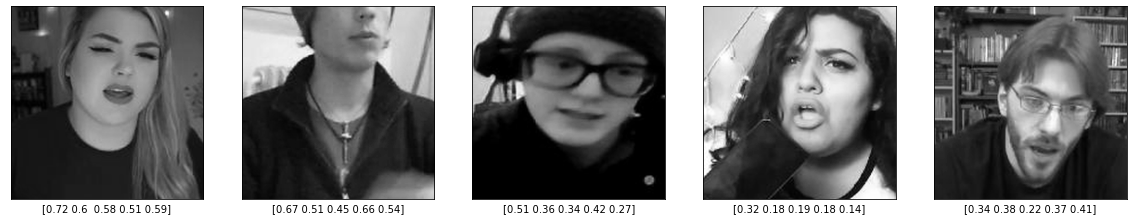

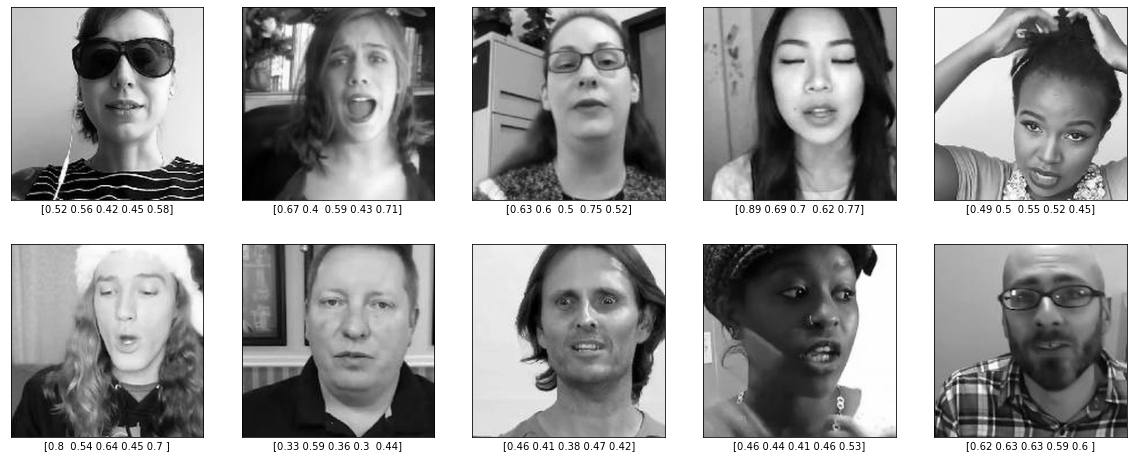

In [5]:
plt.figure(figsize=(20,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_test['X'][i].reshape(208,208), cmap='gray')
    plt.xlabel(str(data_test['Y'][i].round(2)))

plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_train['X'][i].reshape(208,208), cmap='gray')
    plt.xlabel(str(data_train['Y'][i].round(2)))

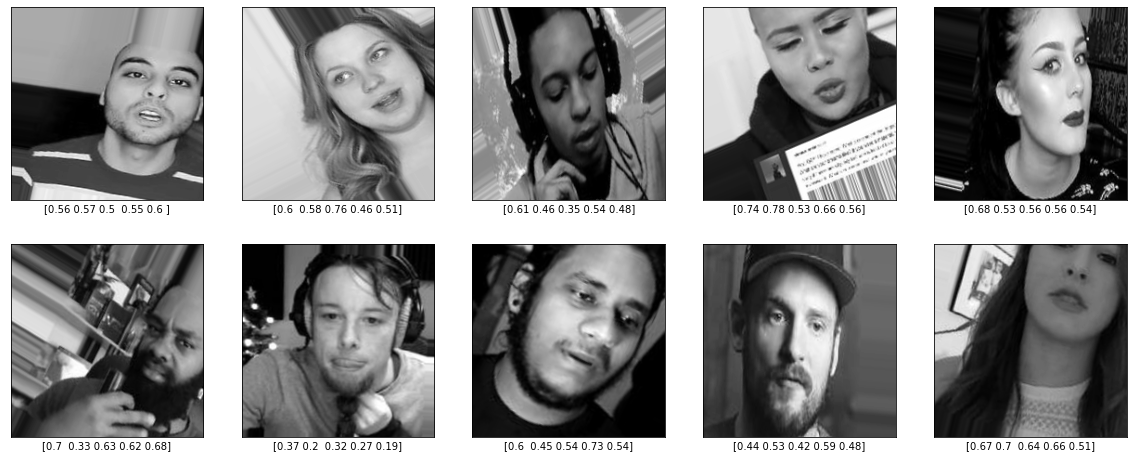

In [6]:
plt.figure(figsize=(20,8))
for X, Y in data_gen_train:
     for i in range(10):
        plt.subplot(2,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i].reshape(208,208), cmap='gray')
        plt.xlabel(str(Y[i].round(2)))
     break
plt.show()

### Optimización de parámetros, entrenamiento de modelos

In [8]:
def build_model(hp):
    # Initialize sequential API and start building model.
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(208, 208, 1)))
    
    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 2 - 5
    # Number of Units: 8 - 512 with stepsize of 32
    for i in range(1, hp.Int("num_conv_layers", 3, 6)):
        model.add(
            keras.layers.Conv2D(
                filters=hp.Int("filters_" + str(i), min_value=8, max_value=512, step=32),
                kernel_size=(3,3),
                activation="relu")
            )
        model.add(keras.layers.MaxPooling2D())
        
        # Tune dropout layer with values from 0 - 0.3 with stepsize of 0.1.
        model.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0, 0.3, step=0.1)))
    
    model.add(keras.layers.Flatten())
    
    for j in range(1, hp.Int("num_dense_layers", 3, 6)):
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(j), min_value=64, max_value=1024, step=32),
                activation="relu")
            )
        
        # Tune dropout layer with values from 0 - 0.3 with stepsize of 0.1.
        model.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0, 0.3, step=0.1)))
    
    # Add output layer.
    model.add(keras.layers.Dense(units=5, activation="relu"))
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mean_squared_error')
    
    return model

In [24]:
# Instantiate the tuner
tuner = kt.Hyperband(build_model,
                     objective="val_loss",
                     max_epochs=25,
                     factor=3,
                     hyperband_iterations=1, #5
                     directory="kt_dir",
                     project_name="kt_hyperband")

In [25]:
# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 9
num_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 4, 'step': 1, 'sampling': None}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 8, 'step': 32, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
filters_2 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 8, 'step': 32, 'sampling': None}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 6, 'step': 1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 32, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 32, 'sampling': None}
learning_ra

In [26]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(data_train['X'], data_train['Y'], epochs=25, validation_split=0.2, callbacks=[stop_early], verbose=2)

Trial 16 Complete [00h 11m 14s]
val_loss: 0.022881392389535904

Best val_loss So Far: 0.020989198237657547
Total elapsed time: 02h 03m 55s

Search: Running Trial #17

Value             |Best Value So Far |Hyperparameter
3                 |3                 |num_conv_layers
8                 |8                 |filters_1
0.2               |0.2               |dropout_1
8                 |8                 |filters_2
0.2               |0.2               |dropout_2
5                 |5                 |num_dense_layers
288               |288               |units_1
192               |192               |units_2
0.001             |0.001             |learning_rate
8                 |8                 |filters_3
0.2               |0.2               |dropout_3
64                |64                |units_3
192               |192               |units_4
224               |224               |units_5
25                |9                 |tuner/epochs
9                 |3                 |tuner/initia

KeyboardInterrupt: 

In [27]:
best_hps=tuner.get_best_hyperparameters()[0]
h_model = tuner.hypermodel.build(best_hps)
#h_model.fit(data_train['X'], data_train['Y'], epochs=25, validation_split=0.2, callbacks=[stop_early], verbose=2)

In [28]:
tuner.results_summary()

Results summary
Results in kt_dir\kt_hyperband
Showing 10 best trials
Trial summary
Hyperparameters:
num_conv_layers: 3
filters_1: 8
dropout_1: 0.2
filters_2: 8
dropout_2: 0.2
num_dense_layers: 5
units_1: 288
units_2: 192
learning_rate: 0.001
filters_3: 8
dropout_3: 0.2
units_3: 64
units_4: 192
units_5: 224
tuner/epochs: 9
tuner/initial_epoch: 3
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0010
Score: 0.020989198237657547
Trial summary
Hyperparameters:
num_conv_layers: 3
filters_1: 8
dropout_1: 0.2
filters_2: 8
dropout_2: 0.2
num_dense_layers: 4
units_1: 960
units_2: 96
learning_rate: 0.001
filters_3: 8
dropout_3: 0.2
units_3: 352
units_4: 256
units_5: 608
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.021000266075134277
Trial summary
Hyperparameters:
num_conv_layers: 3
filters_1: 8
dropout_1: 0.2
filters_2: 8
dropout_2: 0.2
num_dense_layers: 5
units_1: 288
units_2: 192
learning_rate: 0.001
filters_3: 8
dropout_3: 0.2
units_3: 64
units_4: 192
units_5

In [29]:
h_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 206, 206, 8)       80        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 103, 103, 8)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 103, 103, 8)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 101, 101, 8)       584       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 8)        0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 50, 50, 8)        

In [7]:
### CNN
model_cnn = keras.Sequential([
    keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu',input_shape=(208, 208, 1)),
    keras.layers.MaxPooling2D((2,2)),
    
    keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    
    keras.layers.Dense(288, activation='relu'),
    keras.layers.Dense(192, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(192, activation='relu'),
    keras.layers.Dense(5, activation='relu')
])

model_cnn.compile(optimizer='adam', loss='mean_squared_error') #mean_absolute_percentage_error

In [8]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 206, 206, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 103, 103, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 101, 101, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 50, 16)        0         
                                                                 
 flatten (Flatten)           (None, 40000)             0

In [9]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

history_cnn = model_cnn.fit(
    data_gen_train,
    #data_train['X'], data_train['Y'],
    epochs=25, #100
    batch_size=32,
    validation_data=(data_test['X'], data_test['Y']),
    callbacks =[earlystopping],
    steps_per_epoch=int(np.ceil(len(data_train['X']) / float(32))),
    validation_steps=int(np.ceil(len(data_test['X'])/ float(32)))
)

Epoch 1/25
880/880 [==============================] - 158s 178ms/step - loss: 0.1160 - val_loss: 0.0899
Epoch 2/25
880/880 [==============================] - 148s 168ms/step - loss: 0.0850 - val_loss: 0.0888
Epoch 3/25
880/880 [==============================] - 149s 169ms/step - loss: 0.0847 - val_loss: 0.0888
Epoch 4/25
880/880 [==============================] - 146s 166ms/step - loss: 0.0845 - val_loss: 0.0884
Epoch 5/25
880/880 [==============================] - 147s 167ms/step - loss: 0.0844 - val_loss: 0.0884
Epoch 6/25
880/880 [==============================] - 147s 167ms/step - loss: 0.0842 - val_loss: 0.0889
Epoch 7/25
880/880 [==============================] - 147s 167ms/step - loss: 0.0841 - val_loss: 0.0880
Epoch 8/25
880/880 [==============================] - 147s 167ms/step - loss: 0.0840 - val_loss: 0.0881
Epoch 9/25
880/880 [==============================] - 147s 167ms/step - loss: 0.0838 - val_loss: 0.0879
Epoch 10/25
880/880 [==============================] - 146s 166m

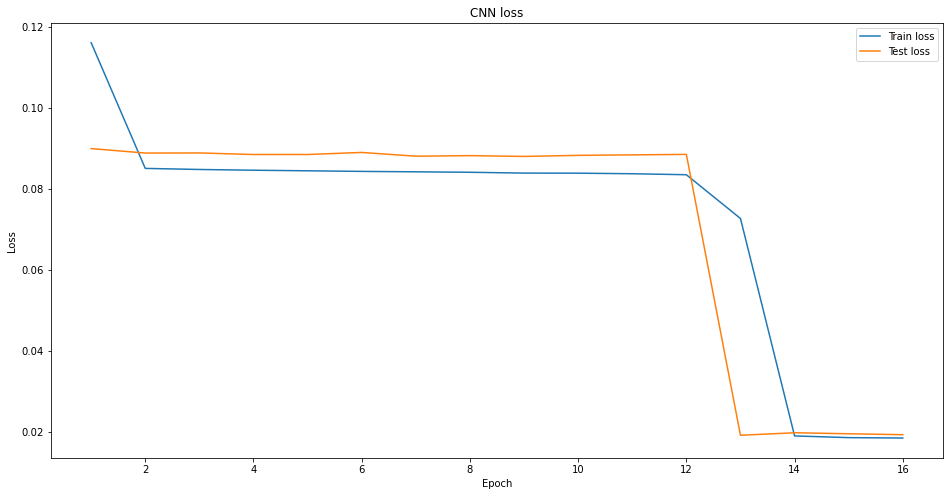

In [10]:
### Graficar el loss por epoch
plt.figure(figsize=(16,8))
plt.plot(np.arange(1,17), history_cnn.history['loss'][0:16])
plt.plot(np.arange(1,17), history_cnn.history['val_loss'][0:16])
plt.title('CNN loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.show()

In [ ]:
predictions_cnn = model_cnn.predict(data_test['X'])
#data_test['Y'][1000], predictions_cnn[1000], predictions_cnn[:5]

In [17]:
def build_model(hp):
    # Initialize sequential API and start building model.
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(208, 208, 1)))
    
    model.add(keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D())
              
    model.add(keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D())
              
    keras.layers.Dropout(0.2),
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Reshape((1,40000)))
    
    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 2 - 5
    # Number of Units: 8 - 512 with stepsize of 32
    for i in range(1, hp.Int("num_lstm_layers", 3, 4)):
        model.add(
            keras.layers.LSTM(
                units=hp.Int("units_" + str(i), min_value=64, max_value=512, step=32),
                activation='relu',
                dropout=hp.Float("dropout_" + str(i), 0, 0.3, step=0.1),
                return_sequences=True)
            )
    
    model.add(keras.layers.LSTM(64, activation='relu', return_sequences=False))
    
    for j in range(1, hp.Int("num_dense_layers", 3, 5)):
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(j), min_value=32, max_value=512, step=32),
                activation="relu")
            )
        
        # Tune dropout layer with values from 0 - 0.3 with stepsize of 0.1.
        model.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0, 0.3, step=0.1)))
    
    # Add output layer.
    model.add(keras.layers.Dense(units=5, activation="relu"))
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mean_squared_error')
    
    return model

In [18]:
# Instantiate the tuner
tuner = kt.Hyperband(build_model,
                     objective="val_loss",
                     max_epochs=25,
                     factor=3,
                     hyperband_iterations=1, #5
                     directory="kt_dir",
                     project_name="kt_hyperband_2")

INFO:tensorflow:Reloading Oracle from existing project kt_dir\kt_hyperband_2\oracle.json


In [19]:
# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 7
num_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 4, 'step': 1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 32, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 32, 'sampling': None}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [20]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(data_train['X'], data_train['Y'], epochs=25, validation_split=0.2, callbacks=[stop_early], verbose=2)

Trial 9 Complete [00h 27m 29s]
val_loss: 0.07246438413858414

Best val_loss So Far: 0.017521865665912628
Total elapsed time: 02h 51m 42s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
4                 |4                 |num_lstm_layers
448               |608               |units_1
0.3               |0                 |dropout_1
928               |448               |units_2
0.1               |0                 |dropout_2
4                 |3                 |num_dense_layers
0.01              |0.001             |learning_rate
352               |64                |units_3
384               |224               |units_4
0                 |0                 |dropout_3
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round



KeyboardInterrupt: 

In [21]:
best_hps=tuner.get_best_hyperparameters()[0]
h_model = tuner.hypermodel.build(best_hps)
#h_model.fit(data_train['X'], data_train['Y'], epochs=25, validation_split=0.2, callbacks=[stop_early], verbose=2)

In [22]:
tuner.results_summary()

Results summary
Results in kt_dir\kt_hyperband_2
Showing 10 best trials
Trial summary
Hyperparameters:
num_lstm_layers: 4
units_1: 608
dropout_1: 0.0
units_2: 448
dropout_2: 0.0
num_dense_layers: 3
learning_rate: 0.001
units_3: 64
units_4: 224
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
dropout_3: 0.0
Score: 0.017521865665912628
Trial summary
Hyperparameters:
num_lstm_layers: 3
units_1: 960
dropout_1: 0.1
units_2: 864
dropout_2: 0.1
num_dense_layers: 4
learning_rate: 0.001
units_3: 416
units_4: 288
dropout_3: 0.1
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.01813553087413311
Trial summary
Hyperparameters:
num_lstm_layers: 3
units_1: 736
dropout_1: 0.2
units_2: 832
dropout_2: 0.0
num_dense_layers: 5
learning_rate: 0.0001
units_3: 192
units_4: 512
dropout_3: 0.30000000000000004
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.01875178888440132
Trial summary
Hyperparameters:
num_lstm_layers: 3
uni

In [23]:
h_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 206, 206, 8)       80        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 103, 103, 8)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 101, 101, 16)      1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 40000)             0         
                                                                 
 reshape_1 (Reshape)         (None, 1, 40000)         

In [11]:
### CNN-LSTM
model_lstm = keras.Sequential([
    keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=(208,208,1)),
    keras.layers.MaxPooling2D((2,2)),
    
    keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Reshape((1,40000)), #(time_steps, features)
    
    keras.layers.LSTM(608, activation='relu', return_sequences=True, dropout=0, recurrent_dropout=0),
    keras.layers.LSTM(448, activation='relu', return_sequences=True),
    keras.layers.LSTM(128, activation='relu', return_sequences=False),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(224, activation='relu'),
    keras.layers.Dense(5, activation='relu')
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 206, 206, 8)       80        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 103, 103, 8)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 101, 101, 16)      1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 50, 50, 16)        0         
                                                                 
 flatten_1 (Flatten)         (None, 40000)            

In [13]:
history_lstm = model_lstm.fit(
    data_gen_train,
    #data_train['X'], data_train['Y'],
    epochs=25, #100
    batch_size=32,
    validation_data=(data_test['X'], data_test['Y']),
    callbacks =[earlystopping],
    steps_per_epoch=int(np.ceil(len(data_train['X']) / float(32))),
    validation_steps=int(np.ceil(len(data_test['X'])/ float(32)))
)

Epoch 1/25
880/880 [==============================] - 430s 485ms/step - loss: 0.0876 - val_loss: 0.0903
Epoch 2/25
880/880 [==============================] - 437s 497ms/step - loss: 0.0850 - val_loss: 0.0889
Epoch 3/25
880/880 [==============================] - 441s 500ms/step - loss: 0.0847 - val_loss: 0.0886
Epoch 4/25
880/880 [==============================] - 440s 500ms/step - loss: 0.0845 - val_loss: 0.0886
Epoch 5/25
880/880 [==============================] - 440s 500ms/step - loss: 0.0607 - val_loss: 0.0205
Epoch 6/25
880/880 [==============================] - 441s 501ms/step - loss: 0.0200 - val_loss: 0.0196
Epoch 7/25
880/880 [==============================] - 440s 500ms/step - loss: 0.0196 - val_loss: 0.0197
Epoch 8/25
880/880 [==============================] - 439s 499ms/step - loss: 0.0195 - val_loss: 0.0193
Epoch 9/25
880/880 [==============================] - 439s 499ms/step - loss: 0.0194 - val_loss: 0.0191
Epoch 10/25
880/880 [==============================] - 441s 501m

In [ ]:
### Graficar el loss por epoch
plt.figure(figsize=(16,8))
plt.plot(np.arange(1,21), history_lstm.history['loss'][0:20])
plt.plot(np.arange(1,21), history_lstm.history['val_loss'][0:20])
plt.title('CNN-LSTM loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.show()

In [14]:
predictions_lstm = model_lstm.predict(data_test['X'])
#data_test['Y'][1000], predictions_lstm[1000], predictions_lstm[:5]

### Guardar modelos

In [15]:
model_cnn.save('cnn.h5')
model_lstm.save('lstm.h5')
#os.mkdir('modelo_cnn_js')
#os.mkdir('modelo_lstm_js')
#tfjs.converters.save_keras_model(model_cnn, 'modelo_cnn_js')
#tfjs.converters.save_keras_model(model_lstm, 'modelo_lstm_js')

In [4]:
### Cargar modelos
model_cnn=keras.models.load_model('cnn.h5')
model_lstm=keras.models.load_model('lstm.h5')

---

### Métricas

In [5]:
predictions_cnn = model_cnn.predict(data_test['X'])
predictions_lstm = model_lstm.predict(data_test['X'])

87/87 [==============================] - 6s 65ms/step


In [6]:
#from sklearn.metrics import mean_absolute_percentage_error
#mean_absolute_percentage_error(y_true, y_pred)
#mean_absolute_percentage_error(data_test['Y'], predictions_cnn)
#mean_absolute_percentage_error(data_test['Y'], predictions_lstm)

In [7]:
def mape(y_true, y_pred):
    error=[];
    for i in range(y_true.shape[1]):
        s=0
        for j in range(y_true.shape[0]):
            if y_true[j][i]!=0:
                s += abs(y_true[j][i] - y_pred[j][i]) / y_true[j][i]
        error.append(s / y_true.shape[0])
    return np.array(error)

In [9]:
modelos = ['CNN', 'CNN + LSTM']; predicciones=[predictions_cnn, predictions_lstm]; metricas={};
for i, modelo in enumerate(modelos):
    mape_ocean = mape(data_test['Y'], predicciones[i])
    mape_total = np.mean(mape_ocean)
    metricas[modelo] = {'MAPE_OCEAN': mape_ocean, 'MAPE': mape_total}
metricas

{'CNN': {'MAPE_OCEAN': array([0.21160593, 0.28543708, 0.30179055, 0.21517102, 0.27167088]),
  'MAPE': 0.2571350927203603},
 'CNN + LSTM': {'MAPE_OCEAN': array([0.20471702, 0.28433521, 0.29350611, 0.21228497, 0.26500249]),
  'MAPE': 0.25196915996773656}}